<a href="https://colab.research.google.com/github/lucassalvino/pnl_grafo_conhecimento/blob/main/NLP_e_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PNL e Grafo de conhecimento**

Processamento de linguagem Natural (PLN) é uma área de estudos multidisciplinares (ciência da computação, inteligência artificial, linguística, lógica e psicologia) que se preocupa com o estudo de modelos matemáticos e computacionais da estrutura da linguagem, seu uso e aquisição, além do desenvolvimento e implementação de sistemas para os fins linguísticos. 

Neste notebook vamos utilizar a PNL para extrair informações de um texto. Como já citado PLN é uma área muito vasta e para facilitar o trabalho existem diversos frameworcks de Processamento de linguagem natural. Caso o leitor queira se aprofundar no assunto, recomendo a leitura de livros (e a velha pesquisa pela internet):

* https://link.springer.com/book/10.1007/978-1-4842-4267-4
* https://www.oreilly.com/library/view/practical-natural-language/9781492054047/
* https://github.com/PacktWorkshops/The-Natural-Language-Processing-Workshop

Além destas referências, também recomento estudos em inteligência artificial (Russell Norvig é um ótimo inicio de estudo: https://www.amazon.com.br/Intelig%C3%AAncia-Artificial-Peter-Norvig/dp/8535237011).


## Extração de informações

Extrair informações é o primeiro passo para inicio de um processo PNL.
As informações a ser extraídas se basiam no conceito de triplos. Um triplo representa um par de entidades e uma relação entre essas entidades:

`O menino anda de bicicleta`

'menino' e 'bicicleta' são as entidades, cuja relação é 'andar'.

Essa já é basicamente a estrutura de um grafo, as entidades se referem a vértices e a relação se refere a aresta de um grafo.

Extrair informações de textos pode ser realizado por diversas abordagens:


1.   **Baseada em regras**: Se define um conjunto de regras para a sintaxe de um texto e utiliza-se essas regras para extrair informações do texto.
2.   **Supervisionado**: Dada entidades já conhecidas, busca-se por relações entre essas entidades.
3. **Semi-supervisionadas**: A busca por informações se inicia a partir de um conjunto de triplos (sementes) já conhecidos.
4. **Não-supervisionadas**: A busca não obtem dados iniciais. Tanto entidades quanto relações serão identificadas a partir de analise sintática do componente linguístico.

Existem frameworks que já possuem implementações capazes de facilitar o trabalho. Neste trabalho, utilizamos o spaCy.

## Grafo de Conhecimento

A teoria de grafo é um ramo da matemática destinada ao estudo de relações de objetos em um conjunto. A computação se beneficia de teoria de grafos pela facilidade em representar, analisar relações e projetar modelos. 

O grafo de conhecimento é uma variação de um grafo convencional anunciado pelo Google em 2012 com o objetivo de atender a necessidade de representação de conhecimento.

O grafo de conhecimento representa uma coleção de descrições interligadas de entidades que possuem uma ou mais relações inequívocas.

De maneira resumida: os vértices são entidades e arestas as relações entre as entidades.

Estude mais sobre grafo e grafos de conhecimento:

- [Algoritmos - Teoria e Prática](https://www.amazon.com.br/Algoritmos-Teoria-Pr%C3%A1tica-Thomas-Cormen/dp/8535236996/ref=asc_df_8535236996/?tag=googleshopp00-20&linkCode=df0&hvadid=379707181411&hvpos=&hvnetw=g&hvrand=1543815962264053639&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9074129&hvtargid=pla-1002925180312&psc=1)

- [GRAFOS DE CONHECIMENTO: PERSPECTIVAS E DESAFIOS PARA A
ORGANIZAÇÃO E REPRESENTAÇÃO DO CONHECIMENTO](https://repositorio.ufscar.br/bitstream/handle/ufscar/13055/GRAFOS%20DE%20CONHECIMENTO%20PERSPECTIVAS%20E%20DESAFIOS%20PARA%20A%20ORGANIZA%c3%87%c3%83O%20E%20REPRESENTA%c3%87%c3%83O%20DO%20CONHECIMENTO_1.pdf?sequence=3&isAllowed=y)

- [Knowledge Graphs with Machine Learning](https://neptune.ai/blog/web-scraping-and-knowledge-graphs-machine-learning)

### SpaCy

- Documentação: https://spacy.io/api
- Idiomas suportados: https://spacy.io/usage/models#languages


Spacy é uma biblioteca de código fonte aberta destinada ao PNL. Possui diversos treinamentos realizados pela comunidade e na maioria das vezes consegue realizar extrações complexas sem a necessidade de se criar uma base de treinamento própria. Além de possuir módulos de interpletação de vários idiomas (inclusive português, embora os melhores resultados sejam obtidos em inglês).

Caso seja necessário realizar um treinamento específico ainda é possível customizar o treinamento que o SpaCy irá utilizar (https://spacy.io/usage/linguistic-features#language-data). 


E iniciando os trabalhos. Não se preocupe com todas as bibliotecas importadas. Será explicado o motivo e sua utlização quando for conveniente.

In [ ]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from bs4.element import Comment
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from IPython.core.display import display, HTML
from spacy.matcher import Matcher




#Carrega o módulo (da comunidade) para o idioma inglês destinado a análise web
nlp = spacy.load('en_core_web_sm')

Como exemplo de processamento:

In [ ]:
#texto a ser analisado
texto = 'the boy rides a bicycle'

#criando objeto spaCy
analise = nlp(texto)

O objeto `analise` já contém a análise sintática do texto. O spacy possui visualizadores para facilitar o entendimento da análise realizada, é o caso do `displacy`.
Obs.: Existem diferenças da utilização do `displacy` em um ambiente real e para notebooks. Para conseguir utilizar sem mais problemas consulte a documentação: https://spacy.io/usage/visualizers

In [ ]:
html = displacy.render(analise, style="dep")
display(HTML(html))

Todos os termos do texto está classificados. Agora precisamos aplicar filtros para obter somente as regiões de interesses.

Os padrões buscados devem ser definidos na variável `padroes`. Ela possui divesos filtros. Ex.: tags gramaticáis, token minusculos, pontuações, comprimento da palavra, texto literal, entre outros. Como sempre, consulte a documentação: https://spacy.io/usage/rule-based-matching

Os padrões aqui escolhidos visão buscar as relações entre as entidades, para isso se assume que o predicado é o verbo principal da frase. Como visto no exemplo, obtemos 'rides'. Resta obter as entidades envolvidas.

In [ ]:
padroes = [{'DEP':'ROOT'}, 
          {'DEP':'prep','OP':"?"},
          {'DEP':'agent','OP':"?"},  
          {'POS':'ADJ','OP':"?"}]
matcher = Matcher(analise.vocab)
matcher.add("matching_1", [padroes])
matches = matcher(analise)
k = len(matches) - 1
span = analise[matches[k][1]:matches[k][2]] 
print(span.text)

rides


As entidades não são complicadas de se obter. Elas estão nas frases originais, basta percorrer essas frases e extrair o sujeito e/ou o objeto quando esses aparecem na frase. No nosso exemplo são somente os substantivos. 

Os métodos abaixo são responsáveis por obter todas as frases do texto original e as entidades de uma frase.

O método `ObtenhaRelacao` é uma abstração da obtenção da relação entre entidades já demonstrada.


In [ ]:
def ObtemFrases(analise_texto):
    frases = set()
    for nc in analise_texto.noun_chunks:
        frases.add(nc.text)
        frases.add(analise_texto[nc.root.left_edge.i:nc.root.right_edge.i+1].text)
    return frases

def ObtemEntidades(NLPFrase):
  entidade1 = ""
  entidade2 = ""
  prevDep = ""
  prevText = ""
  prefix = ""
  modificador = ""
  for tok in NLPFrase:
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prevDep == "compound":
          prefix = prevText + " "+ tok.text
      if tok.dep_.endswith("mod") == True:
        modificador = tok.text
        if prevDep == "compound":
          modificador = prevText + " "+ tok.text
      if tok.dep_.find("subj") == True:
        entidade1 = modificador +" "+ prefix + " "+ tok.text
        prefix = ""
        modificador = ""
        prevDep = ""
        prevText = ""
      if tok.dep_.find("obj") == True:
        entidade2 = modificador +" "+ prefix +" "+ tok.text
      prevDep = tok.dep_
      prevText = tok.text
  return [entidade1.strip().lower(), entidade2.strip().lower()]

def ObtenhaRelacao(sent, nlp):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1", [pattern])
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

O método `ObtemEntidades` foi desenvolvido por Prateek Joshi ([knowledge graph](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/)).

A sua Utilização é simples. O código abaixo cria três estruturas para armazenar todas as informações obtidas:
- `entidades`: Conjunto que contem todas as entidades encontradas
- `ParesEntidades`: Relação entre as entidades (contidas em `entidade`)
- `RelacoesPares`: Relação entre as entidades

Para as entidades em `ParesEntidades[i]` sua relação está em `RelacoesPares[i]`.

In [ ]:
frases = ObtemFrases(analise)
entidades = set()
ParesEntidades = []
RelacoesPares = []

# para cada frase
for frase in frases:
  tmpdoc = nlp(frase)
  entidade = ObtemEntidades(tmpdoc)
  relacao = ObtenhaRelacao(frase, nlp)
  ParesEntidades.append(entidade)
  RelacoesPares.append(relacao.strip().lower())
  for ent in entidade:
      entidades.add(ent)


Agora basta plotar o grafo de conhecimento. A frase em exemplo até agora é muito pequena para plotar um grafo consideravel. Para melhorar o exemplo, vamos realizar o mesmo processo, porém a partir de uma página web.

A página escolhida para realizar o teste é [Earth](https://en.wikipedia.org/wiki/Earth). 


In [ ]:
url = 'https://en.wikipedia.org/wiki/Earth'
requisicao = requests.get(url)
#converte o texto html obtido por get para um objeto
pagina = BeautifulSoup(requisicao.text, 'html.parser')


O objeto `pagina` comtem o html da página referenciada pela `url`. Agora é necessário extrair o texto desse html, para isso as tags de programação serão ignoradas. 

In [ ]:
def TagsVisiveis(elemento):
  if elemento.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
    return False
  if isinstance(elemento, Comment):
    return False
  return True

filtroTextos = pagina.findAll(text=True)
Visiveis = filter(TagsVisiveis, filtroTextos)
texto = u" ".join(t.strip() for t in Visiveis)

print(texto)

            Earth   From Wikipedia, the free encyclopedia     Jump to navigation  Jump to search  Third planet from the Sun in the Solar System  This article is about the planet. For its human aspects, see World . For other uses, see Earth (disambiguation) and Planet Earth (disambiguation) .    Earth The Blue Marble , the most widely used photograph of Earth, [1] [2] taken by the Apollo 17 mission in 1972 Designations Alternative names Gaia , Terra , Tellus , the world , the globe Adjectives Earthly, terrestrial, terran, tellurian Orbital characteristics Epoch  J2000 [n 1] Aphelion 152 100 000 km ( 94 500 000 mi) [n 2] Perihelion 147 095 000 km ( 91 401 000 mi) [n 2] Semi-major axis 149 598 023 km ( 92 955 902 mi) [3] Eccentricity 0.016 7086 [3] Orbital period 365.256 363 004 d [4] ( 31 558.149 7635  ks ) Average orbital speed 29.78 km/s [5] ( 107 200 km/h; 66 600 mph) Mean anomaly 358.617° Inclination 7.155° to the Sun 's equator; 1.578 69 ° [6] to invariable plane ; 0.000 05 ° to J20

Agora basta executarmos a analise NLP e geração de entidades e relações para o texto extraído. O código abaixo faz isto (utilizando-se das funções já criadas):

Obs.: Essa rotina pode demorar, recomendo um pouco de café.

In [ ]:
analise = nlp(texto)
frases = ObtemFrases(analise)
entidades = set()
ParesEntidades = []
RelacoesPares = []

# para cada frase
for frase in frases:
  tmpdoc = nlp(frase)
  entidade = ObtemEntidades(tmpdoc)
  relacao = ObtenhaRelacao(frase, nlp)
  ParesEntidades.append(entidade)
  RelacoesPares.append(relacao.strip().lower())
  for ent in entidade:
      entidades.add(ent)

Basta plotarmos o grafo de conhecimento.
Para plotar estamos utilizando:
- [networkx](https://networkx.org/)
- [matplot](https://matplotlib.org/)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0, flags=flags)


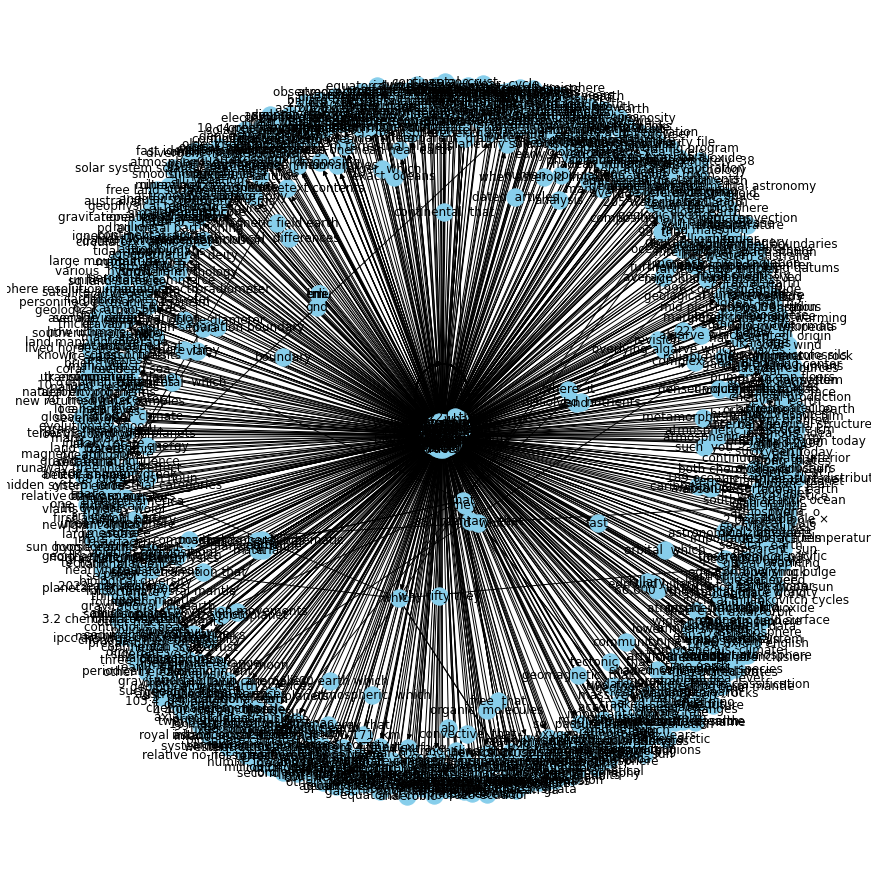

In [ ]:
origem = [i[0] for i in ParesEntidades]
destino = [i[1] for i in ParesEntidades]
kg_df = pd.DataFrame({'source':origem, 'target':destino, 'edge':RelacoesPares})

%matplotlib inline

G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

O grafo de conhecimento foi plotado com sucesso!
Toda a informação que estava representada em texto na wikipedia agora está representado em um grafo, porém o trabalho não para por aqui, o grafo de conhecimento entrega uma poderosa ferramenta de analise de texto e de busca, e as informações realmente interessantes podem ser obtidos a partir deste ponto.

Abaixo segue exemplo de busca por `humans`:

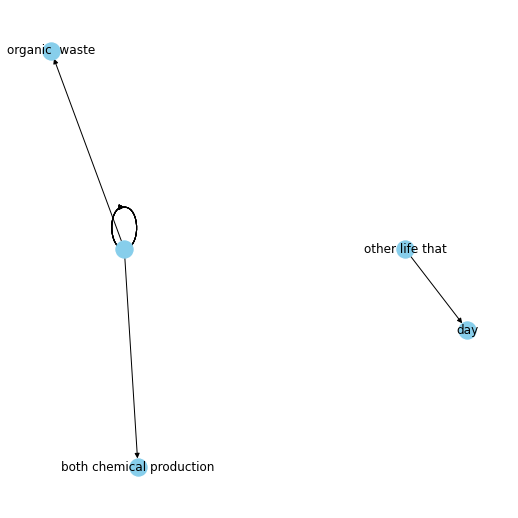

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="humans"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

O resultado apresentado são duas florestas que representam as relações entre as arestas `humans` com as entidades relacionadas.

Este resultado pode melhorar caso se crie um grafo a partir de vários textos.
